In [21]:
# Étape 2 : prédire valueOneA/B puis valueTwoA/B en cascade avec EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Import pour XGBoost et LightGBM
try:
    from xgboost import XGBRegressor
except ImportError:
    XGBRegressor = None
try:
    from lightgbm import LGBMRegressor
except ImportError:
    LGBMRegressor = None


In [6]:
df=pd.read_csv('cleaned_output.csv')


In [12]:
print("=== Aperçu des données ===")
print(df.head())
print("\n=== Informations générales ===")
print(df.info())
print("\n=== Statistiques descriptives (numériques) ===")
print(df.describe())

=== Aperçu des données ===
   genre  age nationalite niveauEtudes                             sessionId  \
0  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
1  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
2  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
3  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   
4  homme   23         HRV        bac+4  420008aa-5136-48fb-9a6f-4347673fce87   

                     textId associationType          personAType  valueOneA  \
0  67a243ea6d8e29a001947946     risk-reward                Robot          8   
1  67a243ea6d8e29a001947945     risk-reward  Femme petite taille          4   
2  67a51efa18a0dfe14aac016b     risk-effort               Enfant          5   
3  67a243ea6d8e29a001947947   effort-reward               Enfant          3   
4  67a243ea6d8e29a001947949   effort-reward  Femme grande taille          5   

   valueTwoA  for

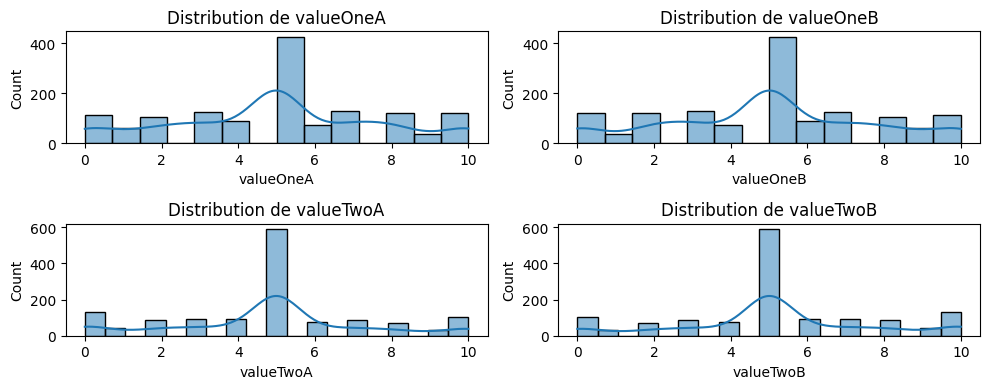

In [13]:
# Colonnes features et targets
feature_cols = [
    'age', 'nationalite', 'genre', 'niveauEtudes',
    'personAType', 'personBType', 'forceA', 'forceB'
]
target1_cols = ['valueOneA', 'valueOneB']
target2_cols = ['valueTwoA', 'valueTwoB']

# Distribution des cibles
plt.figure(figsize=(10,4))
for i, col in enumerate(target1_cols + target2_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

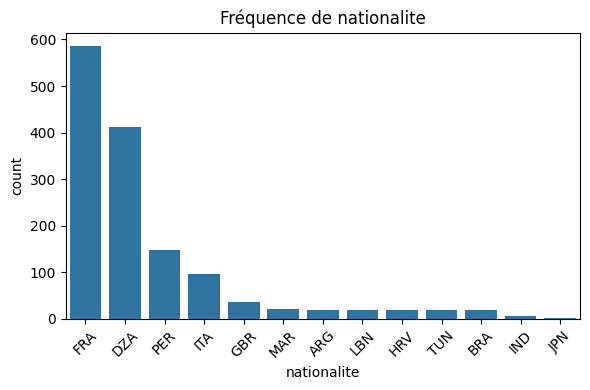

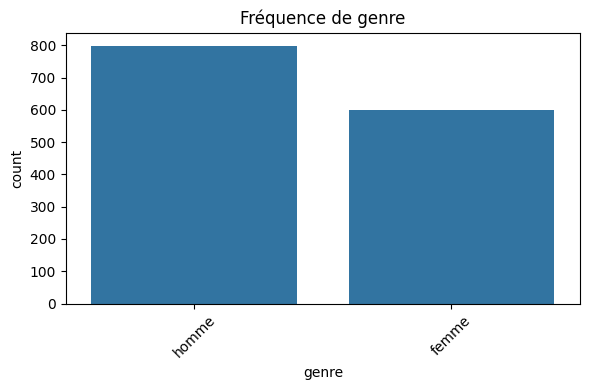

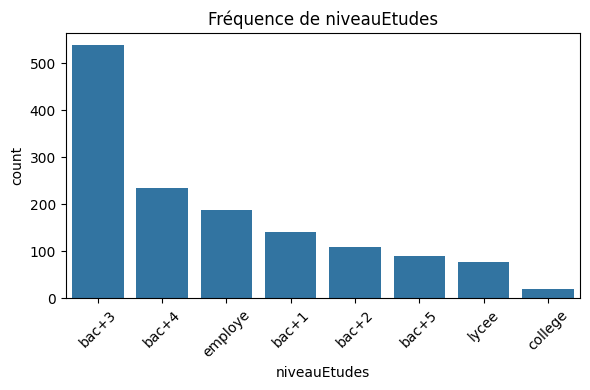

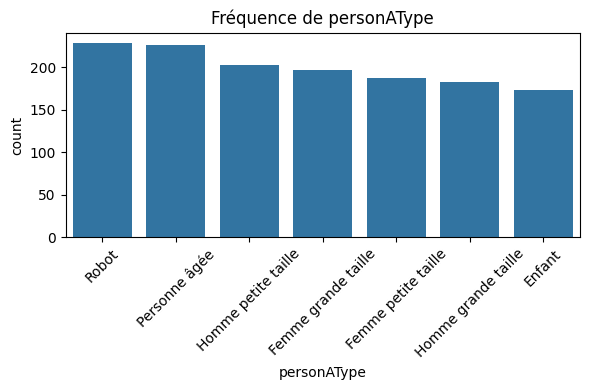

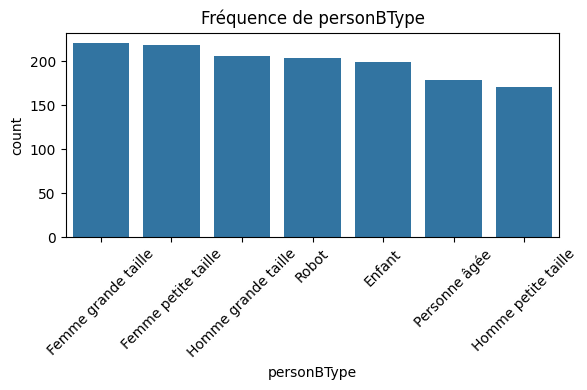

In [14]:
# Distribution des variables catégorielles
cat_cols = ['nationalite', 'genre', 'niveauEtudes', 'personAType', 'personBType']
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Fréquence de {col}')
    plt.tight_layout()
    plt.show()



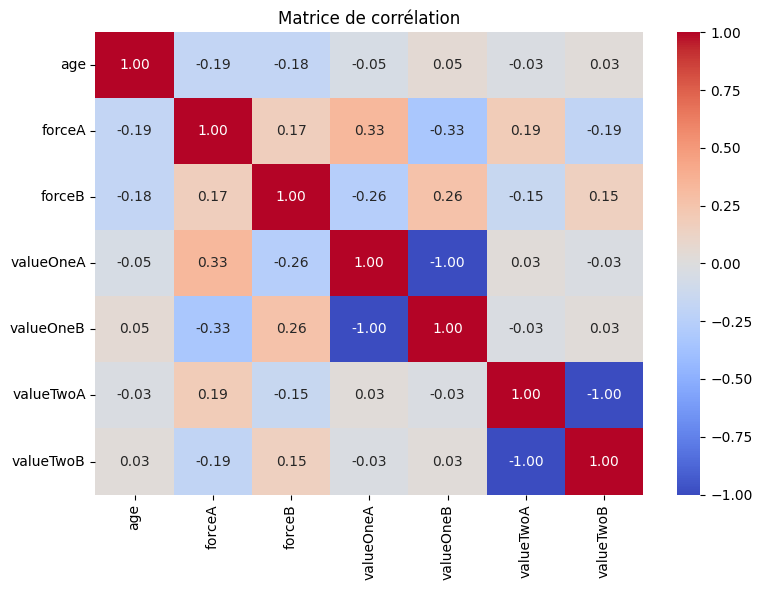

In [16]:
# Corrélations entre variables numériques
num_cols = ['age', 'forceA', 'forceB'] + target1_cols + target2_cols
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.tight_layout()
plt.show()

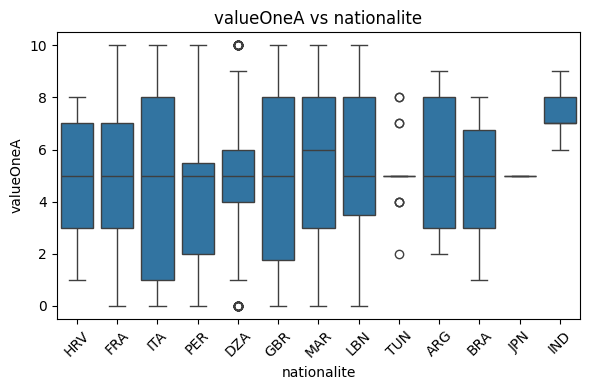

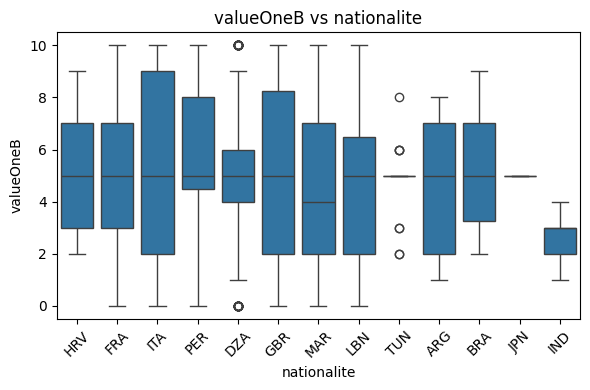

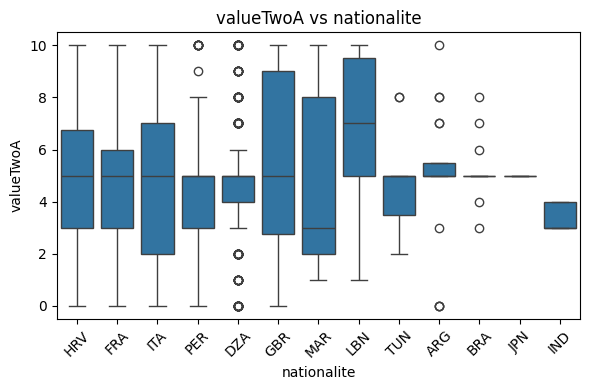

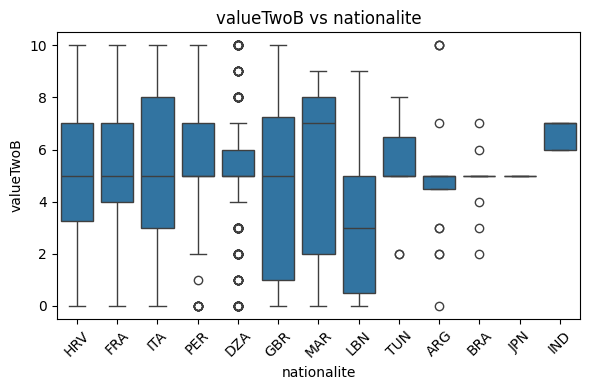

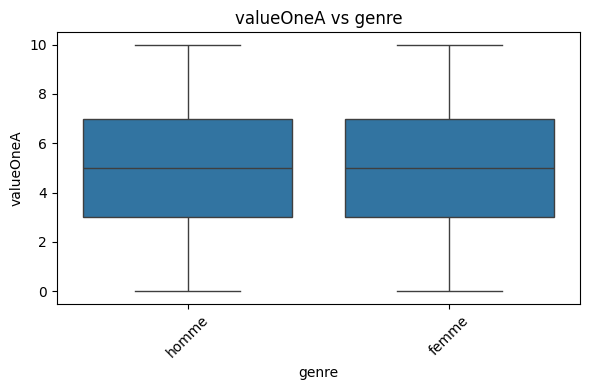

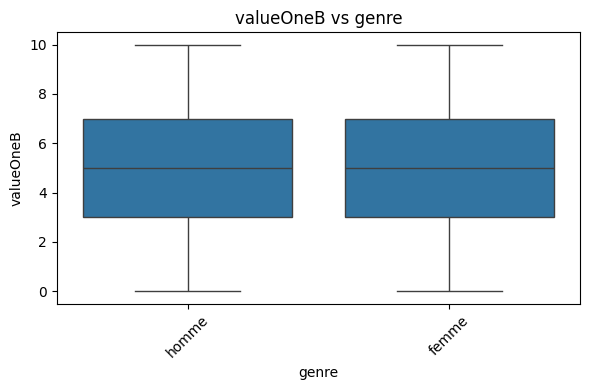

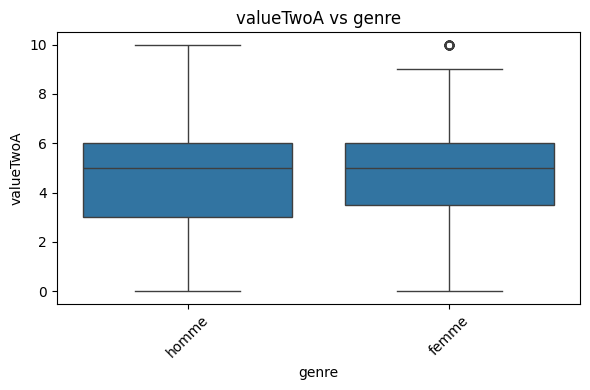

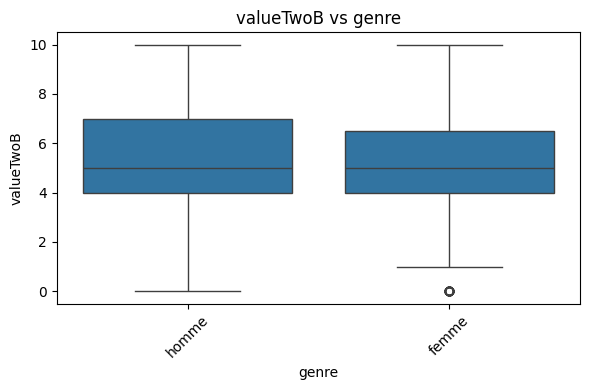

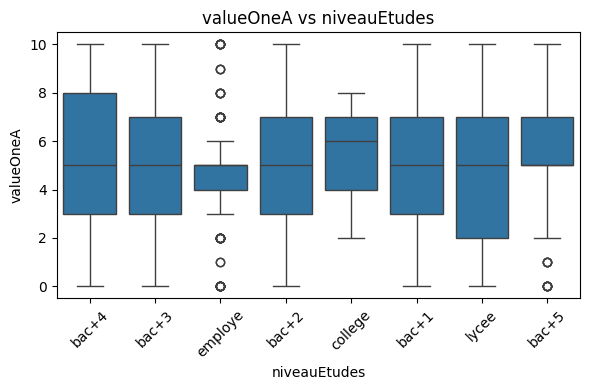

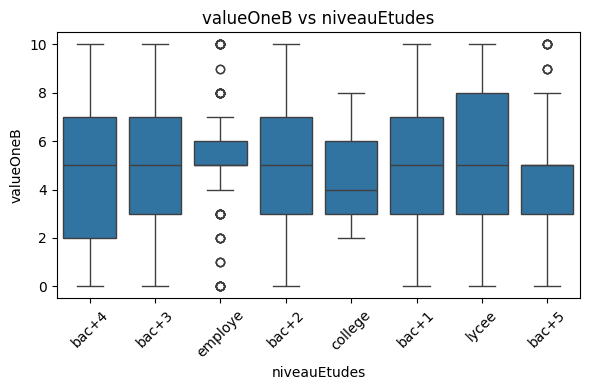

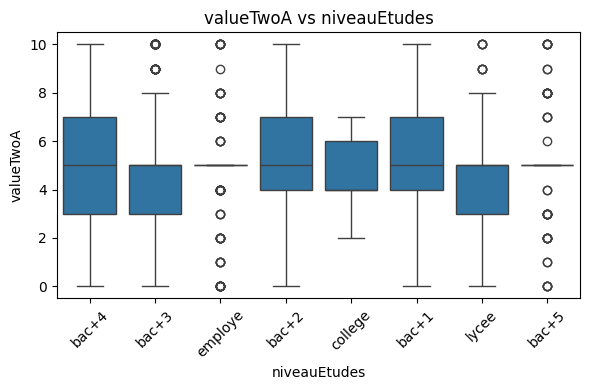

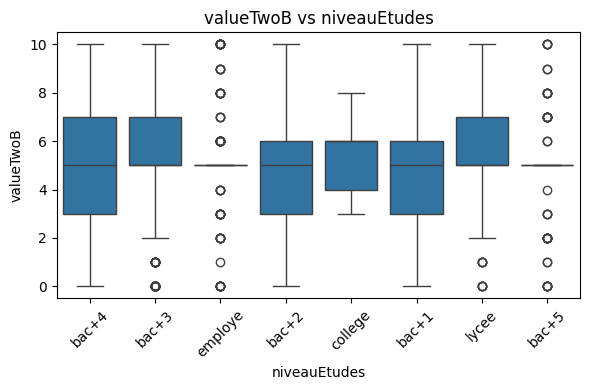

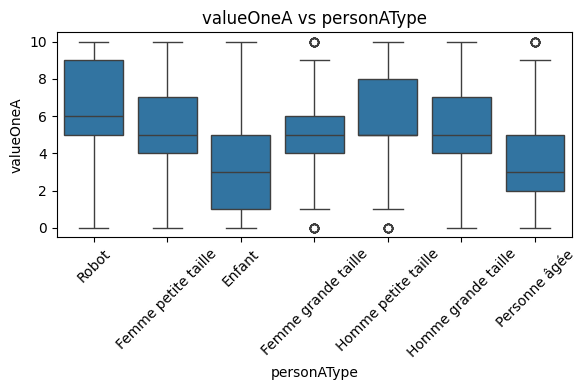

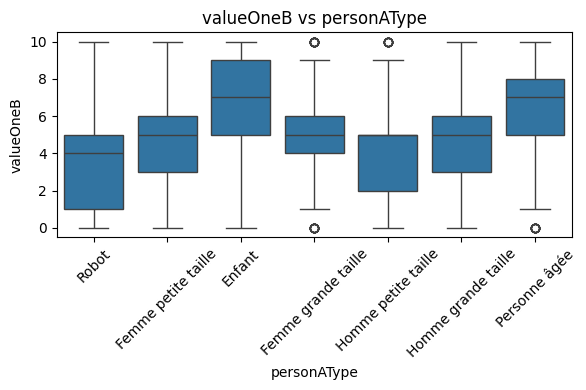

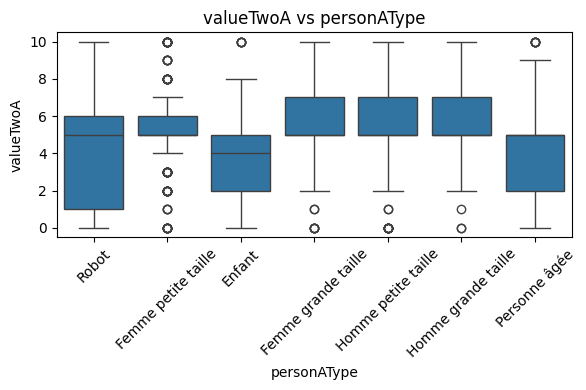

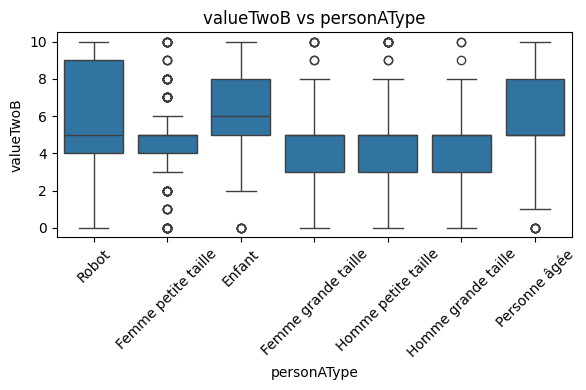

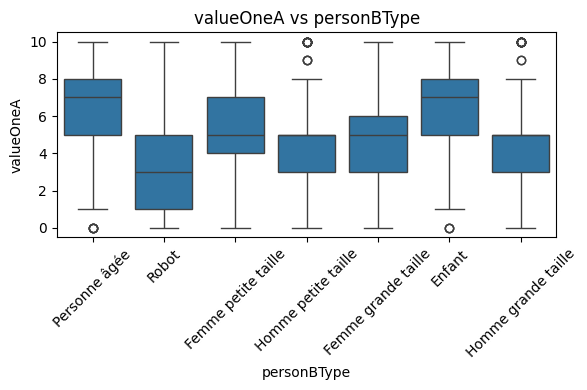

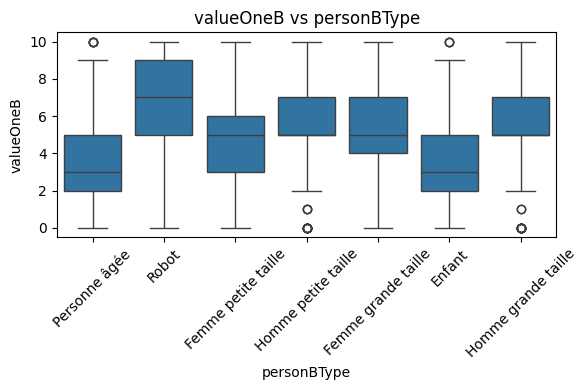

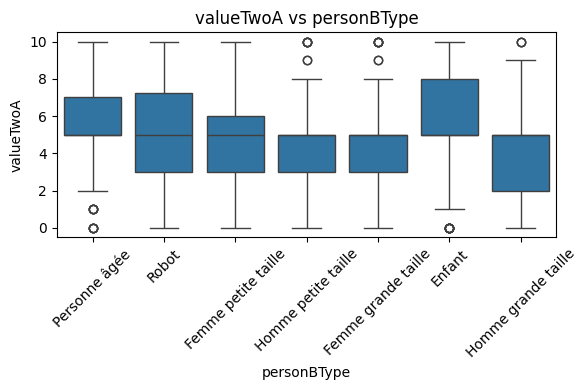

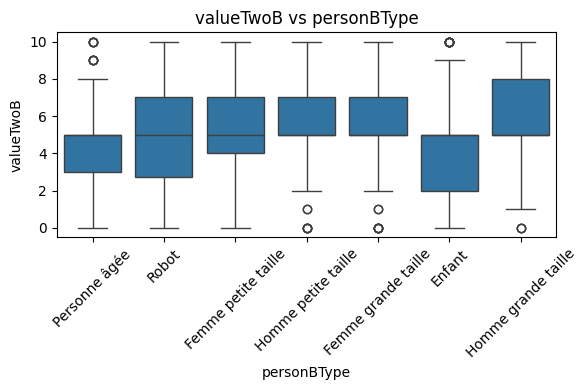

In [17]:
# Relation entre features catégorielles et targets (boxplots)
for cat in cat_cols:
    for col in target1_cols + target2_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(data=df, x=cat, y=col)
        plt.xticks(rotation=45)
        plt.title(f'{col} vs {cat}')
        plt.tight_layout()
        plt.show()

In [18]:
# ----------------------
# 3. Préparation des données
# ----------------------
X = df[feature_cols].copy()
y1 = df[target1_cols].copy()
y2 = df[target2_cols].copy()

# 4. Séparation train/test pour MODELE 1
test_size = 0.2
random_state = 42
X_train, X_test, y1_train, y1_test, y2_train, y2_test = \
    train_test_split(X, y1, y2, test_size=test_size, random_state=random_state)

# 5. Préprocesseur commun (scaling + one-hot)
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

In [25]:
# 6. MODELE 1 : prédiction de valueOneA et valueOneB
model1 = Pipeline([
    ('preproc', preprocessor),
    ('regressor', MultiOutputRegressor(
        RandomForestRegressor(n_estimators=100, random_state=random_state)
    ))
])
model1.fit(X_train, y1_train)
y1_pred_test = model1.predict(X_test)
y1_pred_train = model1.predict(X_train)
rmse1 = np.sqrt(mean_squared_error(y1_test, y1_pred_test, multioutput='raw_values'))
r2_1 = r2_score(y1_test, y1_pred_test, multioutput='raw_values')
print("===== Modèle 1 : valueOneA/B =====")
print(f"RMSE1 [OneA, OneB]: {rmse1}")
print(f"R2_1  [OneA, OneB]: {r2_1}\n")

# 7. Création du second jeu X2 en ajoutant les prédictions OneA/B
#    Pour l'entraînement, on utilise les vraies valeurs y1_train (meilleure source d'information)
X2_train = pd.concat([
    X_train.reset_index(drop=True),
    y1_train.reset_index(drop=True)
        .rename(columns={'valueOneA': 'OneA_pred', 'valueOneB': 'OneB_pred'})
], axis=1)
#    Pour le test, on utilise les prédictions de modèle 1
X2_test = pd.concat([
    X_test.reset_index(drop=True),
    pd.DataFrame(y1_pred_test, columns=['OneA_pred', 'OneB_pred'])
], axis=1)

# 8. Préprocesseur pour MODELE 2 (incluant OneA_pred, OneB_pred)
num_cols2 = num_cols + ['OneA_pred', 'OneB_pred']
preprocessor2 = ColumnTransformer([
    ('num', StandardScaler(), num_cols2),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

# 9. COMPARAISON DE PLUSIEURS MODÈLES POUR MODELE 2 COMPARAISON DE PLUSIEURS MODÈLES POUR MODELE 2
def evaluate_stage2(models, X_tr, y_tr, X_te, y_te):
    results = []
    for name, estimator in models.items():
        if estimator is None:
            continue
        pipe = Pipeline([
            ('preproc', preprocessor2),
            ('regressor', MultiOutputRegressor(estimator))
        ])
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_te)
        rmse = np.sqrt(mean_squared_error(y_te, y_pred, multioutput='raw_values'))
        r2 = r2_score(y_te, y_pred, multioutput='raw_values')
        results.append((name, rmse, r2))
    return results

# Définition des modèles candidates
models2 = {
    'RandomForest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=random_state),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=random_state),
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=random_state) if XGBRegressor else None,
    'LightGBM': LGBMRegressor(n_estimators=200, max_depth=10, learning_rate=0.1, random_state=random_state) if LGBMRegressor else None
}

# Évaluation et affichage
results2 = evaluate_stage2(models2, X2_train, y2_train, X2_test, y2_test)
print("===== Résultats comparés pour Modèle 2 (valueTwoA/B) =====")
for name, rmse, r2 in results2:
    print(f"{name}: RMSE [TwoA, TwoB] = {rmse}, R2 = {r2}")


===== Modèle 1 : valueOneA/B =====
RMSE1 [OneA, OneB]: [2.54843574 2.54685853]
R2_1  [OneA, OneB]: [0.16524461 0.16627753]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 1118, number of used features: 29
[LightGBM] [Info] Start training from score 4.855098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

/Users/salhinina/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
